In [2]:
import os
import imp
import torch
import random
import torchvision

import img_dataset_class


import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim


from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models

from img_dataset_class import ImgsDataset

from sklearn.model_selection import train_test_split


In [51]:
# Global vars

SEED = 127
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test1'
TRAIN_BATCHSIZE = 32
TEST_BATCHSIZE = 128

EPOCHS_sfmmd = 7
EPOCHS_densn121 = 7
EPOCHS_resnet18 = 7

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

READY_MODELS_PATH = 'saved_models/'

# Important for reproducibility (manual_seed)

In [4]:
torch.manual_seed(SEED)

# Data first look

In [5]:
# get labels

labels_list = []
train_imgs = os.listdir('data/train')

for f in train_imgs:
    
    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label 
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [6]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.head(3)

,image,label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0


In [7]:
df_train['label'].unique()

array([0, 1], dtype=int64)

<Figure size 864x864 with 0 Axes>

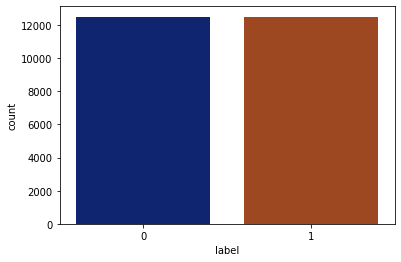

<Figure size 864x864 with 0 Axes>

In [8]:
sns.countplot(data= df_train, x= 'label', palette= 'dark')
plt.figure(figsize=(12,12))

In [10]:
shape_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])

    with Image.open(img_path) as img:
        width, height = img.size
        shape_arr.append((width, height))

np.unique(shape_arr, axis= 0).__len__()

KeyboardInterrupt: 

In [12]:
np.max(shape_arr, axis= 0)

array([500, 500])

In [13]:
np.min(shape_arr, axis= 0)

array([50, 49])

### *NOTE*: 8513 unique shapes of images, so reshape need.

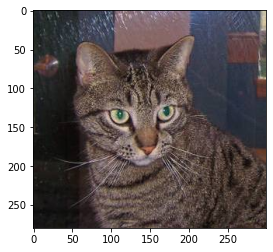

In [9]:
img_path = os.path.join(TRAIN_PATH, df_train['image'][1])

with Image.open(img_path) as img:
    plt.imshow(img)

# Mean and std to reshape and normalize

## Mean (channels)

In [20]:
r_mean_arr = []
g_mean_arr = []
b_mean_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_mean, g_mean, b_mean = np.mean(img_np, axis= (0,1))

        r_mean_arr.append(r_mean)
        g_mean_arr.append(g_mean)
        b_mean_arr.append(b_mean)


KeyboardInterrupt: 

In [ ]:
R_MEAN = np.mean(r_mean_arr) / 255
G_MEAN = np.mean(g_mean_arr) / 255
B_MEAN = np.mean(b_mean_arr) / 255

In [ ]:
print(f"Red ch mean   = {R_MEAN}\nGreen ch mean = {G_MEAN}\nBlue ch mean  = {B_MEAN}")

Red ch mean   = 0.48832284218884975
Green ch mean = 0.45508163042054794
Blue ch mean  = 0.4169560571643627


## Std (channels)

In [ ]:
r_std_arr = []
g_std_arr = []
b_std_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_std, g_std, b_std = np.std(img_np, axis= (0,1))

        r_std_arr.append(r_std)
        g_std_arr.append(g_std)
        b_std_arr.append(b_std)


In [ ]:
R_STD = np.mean(r_std_arr) / 255
G_STD = np.mean(g_std_arr) / 255
B_STD = np.mean(b_std_arr) / 255

In [ ]:
print(f"Red ch std   = {R_STD}\nGreen ch std = {G_STD}\nBlue ch std  = {B_STD}")

Red ch std   = 0.22944326551560382
Green ch std = 0.22498400642892036
Blue ch std  = 0.22518627654899104


# Train/test split and samples visual

In [13]:

X_train, X_test, y_train, y_test = train_test_split(df_train['image'], df_train['label'], test_size= 0.15, random_state= SEED, stratify= df_train['label'])

print(f'Train size = {X_train.shape[0]}\nTest size = {X_test.shape[0]}')

Train size = 21250
Test size = 3750


<AxesSubplot:xlabel='label', ylabel='count'>

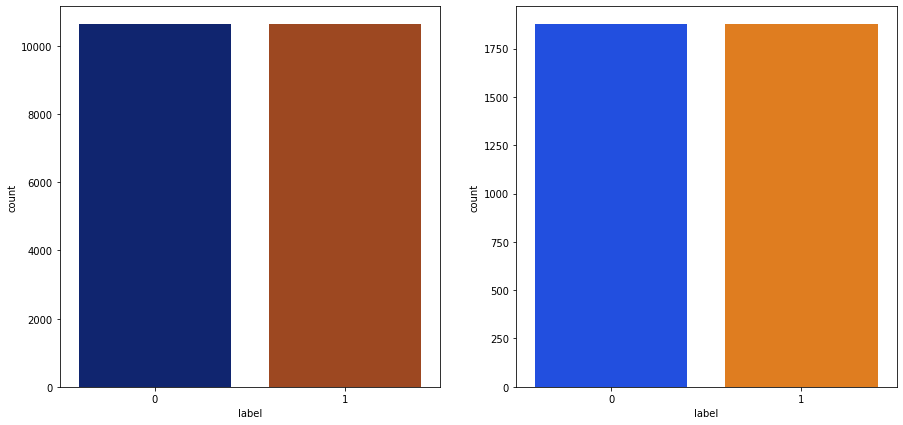

In [14]:
# stratified check

fig, axs = plt.subplots(1,2, figsize= (15,7))

sns.countplot(x= y_train, ax= axs[0], palette= 'dark')
sns.countplot(x= y_test, ax= axs[1], palette= 'bright')

# Transforms

In [15]:
train_transforms = transforms.Compose(
    [transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

In [16]:
test_transforms =  transforms.Compose(
    [transforms.Resize((128, 128)),
    transforms.ToTensor(), 
    #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

# Creating train/test custom datasets and loader

In [17]:
imp.reload(img_dataset_class)

train_set = ImgsDataset(X_train, y_train, TRAIN_PATH, transforms_= train_transforms)
test_set = ImgsDataset(X_test, y_test, TRAIN_PATH, transforms_= test_transforms)

0 (3, 128, 128) 1
1 (3, 128, 128) 1
2 (3, 128, 128) 1
3 (3, 128, 128) 0


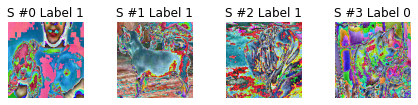

In [18]:
for i in range(len(train_set)):
    sample, label = train_set[i]

    print(i, sample.shape, label)

    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()

    tr = transforms.ToPILImage()

    plt.imshow(tr(torch.Tensor(sample)))
    ax.set_title(f'S #{i} Label {label}')
    ax.axis('off')
    

    if i == 3:
        plt.show()
        break

In [19]:
test_loader = DataLoader(test_set, batch_size = TEST_BATCHSIZE, shuffle= True, num_workers= 0)

In [20]:
train_loader = DataLoader(train_set, batch_size= TRAIN_BATCHSIZE, shuffle=True, num_workers= 0)

In [21]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    
    if ((i_batch % 3 == 0) & (i_batch != 0)):
        break

0 torch.Size([32, 3, 128, 128]) torch.Size([32])
1 torch.Size([32, 3, 128, 128]) torch.Size([32])
2 torch.Size([32, 3, 128, 128]) torch.Size([32])
3 torch.Size([32, 3, 128, 128]) torch.Size([32])


# Implementing self-made CNN model

In [42]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # layer1
        self.cv1 = nn.Conv2d(in_channels= 3, out_channels= 10, kernel_size= 3)
        self.batch_norm1 = nn.BatchNorm2d(num_features= 10)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)

        # layer2
        self.cv2 = nn.Conv2d(in_channels= 10, out_channels= 15, kernel_size= 3)
        self.batch_norm2 = nn.BatchNorm2d(num_features= 15)
        self.relu2 = nn.ReLU()


        # layer3
        self.cv3 = nn.Conv2d(in_channels= 15, out_channels= 20, kernel_size= 3)
        self.batch_norm3 = nn.BatchNorm2d(num_features= 20)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(2)

        # fc1
        self.fc1 = nn.Linear(16820, 2000)
        self.relu_fc1 = nn.ReLU()

        # fc1
        self.fc2 = nn.Linear(2000, 500)
        self.relu_fc2 = nn.ReLU()

        # fc1
        self.fc3 = nn.Linear(500, 2)
        
        #self.log_softmax = nn.Softmax(dim= 1)
        #self.sigm3 = nn.Sigmoid()


    def forward(self, x):
        # l1
        x = self.max_pool1(self.relu1(self.batch_norm1(self.cv1(x))))

        # l2
        x = self.relu2(self.batch_norm2(self.cv2(x)))

        # l3
        x = self.max_pool3(self.relu3(self.batch_norm3(self.cv3(x))))

        x = x.view(x.size(0), -1)


        # fc 1,2,3
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))

        x = self.fc3(x)
        
        #x = self.sigm3(x)
        #x = self.log_softmax(self.fc3(x))

        return x

# Train function

In [22]:
def train_cycle(model, optimizer, criterion, p_iter, n_epochs):
    
    model.train()

    itr = 1
    total_loss = 0
    loss_list = []
    acc_list = []
    for epoch in range(n_epochs):
        for batch_no, data in enumerate(train_loader, 0):

            samples, labels = data

            optimizer.zero_grad()

            output = model(samples)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if itr%p_iter == 0:
                pred = torch.argmax(output, dim=1)
                correct = pred.eq(labels)
                acc = torch.mean(correct.float())
                print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, n_epochs, itr, total_loss/p_iter, acc))
                loss_list.append(total_loss/p_iter)
                acc_list.append(acc)
                total_loss = 0

            itr += 1

    plt.plot(loss_list[1:], label='loss')
    plt.plot(acc_list[1:], label='accuracy')
    plt.legend()
    plt.title('training loss and accuracy')
    plt.show()
    print('Finished Training')

In [40]:
net = ConvNet()
print(net)

ConvNet(
  (cv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (cv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16820, out_features=2000, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=2000, out_features=500, bias=True)
  (relu_fc2): ReLU()
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)


In [41]:
optimizer = optim.Adam(net.parameters(), lr=0.008)
criterion = nn.CrossEntropyLoss()

[Epoch 1/7] Iteration 300 -> Train Loss: 0.5161, Accuracy: 0.625
[Epoch 1/7] Iteration 600 -> Train Loss: 0.5236, Accuracy: 0.719
[Epoch 2/7] Iteration 900 -> Train Loss: 0.4712, Accuracy: 0.812
[Epoch 2/7] Iteration 1200 -> Train Loss: 0.4690, Accuracy: 0.812
[Epoch 3/7] Iteration 1500 -> Train Loss: 0.4512, Accuracy: 0.844
[Epoch 3/7] Iteration 1800 -> Train Loss: 0.4472, Accuracy: 0.719
[Epoch 4/7] Iteration 2100 -> Train Loss: 0.4514, Accuracy: 0.906
[Epoch 4/7] Iteration 2400 -> Train Loss: 0.4332, Accuracy: 0.750
[Epoch 5/7] Iteration 2700 -> Train Loss: 0.4097, Accuracy: 0.812
[Epoch 5/7] Iteration 3000 -> Train Loss: 0.3973, Accuracy: 0.781
[Epoch 5/7] Iteration 3300 -> Train Loss: 0.4052, Accuracy: 0.719
[Epoch 6/7] Iteration 3600 -> Train Loss: 0.3896, Accuracy: 0.844
[Epoch 6/7] Iteration 3900 -> Train Loss: 0.3919, Accuracy: 0.875
[Epoch 7/7] Iteration 4200 -> Train Loss: 0.4032, Accuracy: 0.844
[Epoch 7/7] Iteration 4500 -> Train Loss: 0.3580, Accuracy: 0.750


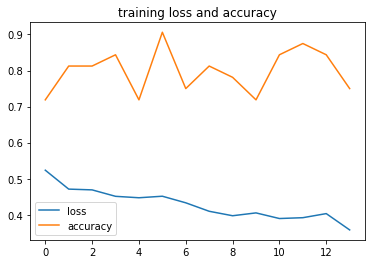

Finished Training


In [46]:
#Self-made model train

train_cycle(net, optimizer, criterion, 300,  n_epochs= EPOCHS_sfmmd)

# Transfer learning attemp

## Densnet121(pretrained)

In [19]:
#torchvision.models

densn121 = models.densenet121(pretrained=True)

In [20]:
optimizer = optim.Adam(densn121.parameters(), lr=0.007)
criterion = nn.CrossEntropyLoss()

In [21]:
num_ftrs = densn121.classifier.in_features
densn121.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)


[Epoch 1/7] Iteration 300 -> Train Loss: 0.6768, Accuracy: 0.656
[Epoch 1/7] Iteration 600 -> Train Loss: 0.6357, Accuracy: 0.625
[Epoch 2/7] Iteration 900 -> Train Loss: 0.5872, Accuracy: 0.812
[Epoch 2/7] Iteration 1200 -> Train Loss: 0.5299, Accuracy: 0.875
[Epoch 3/7] Iteration 1500 -> Train Loss: 0.5010, Accuracy: 0.688
[Epoch 3/7] Iteration 1800 -> Train Loss: 0.4551, Accuracy: 0.812
[Epoch 4/7] Iteration 2100 -> Train Loss: 0.4140, Accuracy: 0.812
[Epoch 4/7] Iteration 2400 -> Train Loss: 0.3720, Accuracy: 0.906
[Epoch 5/7] Iteration 2700 -> Train Loss: 0.3384, Accuracy: 0.906
[Epoch 5/7] Iteration 3000 -> Train Loss: 0.3057, Accuracy: 0.844
[Epoch 5/7] Iteration 3300 -> Train Loss: 0.2859, Accuracy: 0.969
[Epoch 6/7] Iteration 3600 -> Train Loss: 0.2767, Accuracy: 0.812
[Epoch 6/7] Iteration 3900 -> Train Loss: 0.2449, Accuracy: 0.906
[Epoch 7/7] Iteration 4200 -> Train Loss: 0.2419, Accuracy: 0.875
[Epoch 7/7] Iteration 4500 -> Train Loss: 0.2314, Accuracy: 0.906


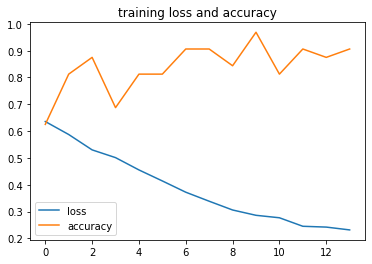

Finished Training


In [22]:
train_cycle(densn121, optimizer= optimizer, criterion= criterion, p_iter= 300, n_epochs= EPOCHS_densn121)

## ResNet18

In [28]:
resnet18 = models.resnet18(pretrained=True)

In [29]:
optimizer = optim.Adam(resnet18.parameters(), lr=0.009)
criterion = nn.CrossEntropyLoss()

In [30]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

[Epoch 1/7] Iteration 300 -> Train Loss: 0.7163, Accuracy: 0.531
[Epoch 1/7] Iteration 600 -> Train Loss: 0.6534, Accuracy: 0.688
[Epoch 2/7] Iteration 900 -> Train Loss: 0.6429, Accuracy: 0.625
[Epoch 2/7] Iteration 1200 -> Train Loss: 0.6074, Accuracy: 0.562
[Epoch 3/7] Iteration 1500 -> Train Loss: 0.6111, Accuracy: 0.812
[Epoch 3/7] Iteration 1800 -> Train Loss: 0.5688, Accuracy: 0.812
[Epoch 4/7] Iteration 2100 -> Train Loss: 0.5307, Accuracy: 0.594
[Epoch 4/7] Iteration 2400 -> Train Loss: 0.4867, Accuracy: 0.719
[Epoch 5/7] Iteration 2700 -> Train Loss: 0.4682, Accuracy: 0.781
[Epoch 5/7] Iteration 3000 -> Train Loss: 0.4197, Accuracy: 0.844
[Epoch 5/7] Iteration 3300 -> Train Loss: 0.3925, Accuracy: 0.969
[Epoch 6/7] Iteration 3600 -> Train Loss: 0.3583, Accuracy: 0.906
[Epoch 6/7] Iteration 3900 -> Train Loss: 0.3221, Accuracy: 0.719
[Epoch 7/7] Iteration 4200 -> Train Loss: 0.3037, Accuracy: 0.938
[Epoch 7/7] Iteration 4500 -> Train Loss: 0.2749, Accuracy: 0.844


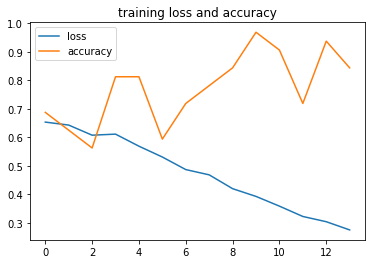

Finished Training


In [31]:
train_cycle(resnet18, optimizer= optimizer, criterion= criterion, p_iter= 300, n_epochs= EPOCHS_resnet18)

# Tests

In [32]:
def test_model(model, test_data, criterion):

    model.eval()

    acc_list = []
    loss_list = []
    val_loss = 0
    with torch.no_grad():
        for batch_no, data in tqdm(enumerate(test_data, 0)):
            samples, labels = data

            output = model(samples)
            loss = criterion(output, labels)
            
            val_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            acc_list.append(acc)
            loss_list.append(loss)

    print(f'Mean acc = {np.mean(acc_list): .3f}. Mean loss = {np.mean(loss_list): .3f}')

            

In [33]:
criterion = nn.CrossEntropyLoss()

In [78]:
print('Self-made ConvNet:')
test_model(net, test_loader, criterion)

Self-made ConvNet:


30it [00:15,  1.95it/s]

Mean acc =  0.802. Mean loss =  0.442


In [34]:
print('ResNet18:')
test_model(resnet18, test_loader, criterion)

ResNet18:


30it [01:32,  3.07s/it]

Mean acc =  0.886. Mean loss =  0.267


In [30]:
print('DensNet121:')
test_model(densn121, test_loader, criterion)

DensNet121:


30it [02:11,  4.39s/it]

Mean acc =  0.886. Mean loss =  0.252


# Save models

In [85]:
torch.save(net.state_dict(), os.path.join(READY_MODELS_PATH, 'smConvNet.pt'))


# TO LOAD:
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [31]:
torch.save(densn121.state_dict(), os.path.join(READY_MODELS_PATH, 'densn121.pt'))


In [35]:
torch.save(resnet18.state_dict(), os.path.join(READY_MODELS_PATH, 'resnet18.pt'))

# Load models

In [43]:
cnn_m = ConvNet()
cnn_m.load_state_dict(torch.load(os.path.join(READY_MODELS_PATH, 'smConvNet.pt')))
cnn_m

ConvNet(
  (cv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (cv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16820, out_features=2000, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=2000, out_features=500, bias=True)
  (relu_fc2): ReLU()
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)

In [38]:
resnet18_loaded = models.resnet18()

num_ftrs = resnet18_loaded.fc.in_features
resnet18_loaded.fc = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

resnet18_loaded.load_state_dict(torch.load(os.path.join(READY_MODELS_PATH, 'resnet18.pt')))

<All keys matched successfully>

In [39]:
densn121_loaded = models.densenet121()

num_ftrs = densn121_loaded.classifier.in_features
densn121_loaded.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

densn121_loaded.load_state_dict(torch.load(os.path.join(READY_MODELS_PATH, 'densn121.pt')))

<All keys matched successfully>

In [49]:
models_list = []
models_list.append(cnn_m)
models_list.append(resnet18_loaded)
models_list.append(densn121_loaded)

for i in models_list:
    print(type(i))

<class '__main__.ConvNet'>
<class 'torchvision.models.resnet.ResNet'>
<class 'torchvision.models.densenet.DenseNet'>


# Predictions

In [57]:
# Load test set for submission

test_imgs_f = os.listdir(TEST_PATH)
labels_list_fake = [0] * len(test_imgs_f)
test_ids = []



for file_name in test_imgs_f:
    test_ids.append(file_name.split('.')[0])


print(f'Images count = {len(test_ids)}\nLabels count = {len(labels_list_fake)}')

Images count = 12500
Labels count = 12500


In [59]:
df_test_f = pd.DataFrame(columns= ['image', 'label'])
df_test_f['image'] = test_imgs_f
df_test_f['label'] = labels_list_fake

test_set_final = ImgsDataset(df_test_f['image'], df_test_f['label'], TEST_PATH, transforms_= test_transforms)
test_set_final

In [60]:
test_loader_final = DataLoader(test_set_final, TEST_BATCHSIZE)

In [107]:
for i in models_list:

    preds_final = torch.Tensor()

    predictions_frame = pd.DataFrame(columns= ['ids', 'preds'])
    predictions_frame['ids'] = test_ids

    i.eval()
    
    with torch.no_grad():
        for batch_no, data in tqdm(enumerate(test_loader_final, 0)):
            samples, labels = data

            output = i(samples)

            pred = torch.argmax(output, dim=1)


            preds_final = torch.concat((preds_final, pred), 0)

            #print(len(preds_final))

        
    predictions_frame['preds'] = preds_final
    
    name = str(i)
    name = name[:7].strip()
    predictions_frame.to_csv(f'{name}.csv', header= False, index= False)


98it [01:02,  1.57it/s]
98it [02:08,  1.31s/it]
98it [06:29,  3.97s/it]


In [110]:
# Records check

preds_fchech = pd.read_csv('ConvNet.csv', header= None)
print(f'Self-made CNN preds ---{preds_fchech[1].unique()}')

preds_fchech = pd.read_csv('DenseNe.csv', header= None)
print(f'DensNet121 preds    ---{preds_fchech[1].unique()}')

preds_fchech = pd.read_csv('ResNet(.csv', header= None)
print(f'Resnet18 preds      ---{preds_fchech[1].unique()}')

Self-made CNN preds ---[0. 1.]
DensNet121 preds    ---[1. 0.]
Resnet18 preds      ---[1. 0.]
